## Setup

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "../database/seed.csv"

try:
    df = pd.read_csv(csv_path)
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print(f"Arquivo não encontrado no caminho: {csv_path}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")


Dataset carregado com sucesso!


In [10]:
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")
print("\nColunas do dataset:")
print(df.columns)


print("\nPrimeiras 5 linhas do dataset:")
print(df.head())


print("\nTipos de dados e valores ausentes:")
print(df.info())
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Número de linhas: 3521
Número de colunas: 11

Colunas do dataset:
Index(['id', 'date', 'type', 'description', 'payment_method', 'bank', 'value',
       'categories', 'notes', 'month', 'year'],
      dtype='object')

Primeiras 5 linhas do dataset:
   id       date     type                                        description  \
0   1 2024-01-02  CREDITO                       CRED PIX HORFRAN - NF-e 4453   
1   2 2024-01-03  CREDITO  CRED TED BRASANITAS HOSPITALAR HIGIEN - NFS-e ...   
2   3 2024-01-05   DEBITO                ENVIO TEV ROBSON - PAGTO DE SALÁRIO   
3   4 2024-01-05   DEBITO                ENVIO PIX BRENDA - PAGTO DE SALÁRIO   
4   5 2024-01-05   DEBITO               ENVIO PIX CINTHYA - PAGTO DE SALÁRIO   

  payment_method   bank    value                             categories notes  \
0            PIX  CAIXA   260.00  Recebimento, Pagamento de Nota Fiscal   NaN   
1  TRANSFERENCIA  CAIXA   585.00     Recebimento, Serviços Hospitalares   NaN   
2  TRANSFERENCIA  CAIXA  2145

## Exploração

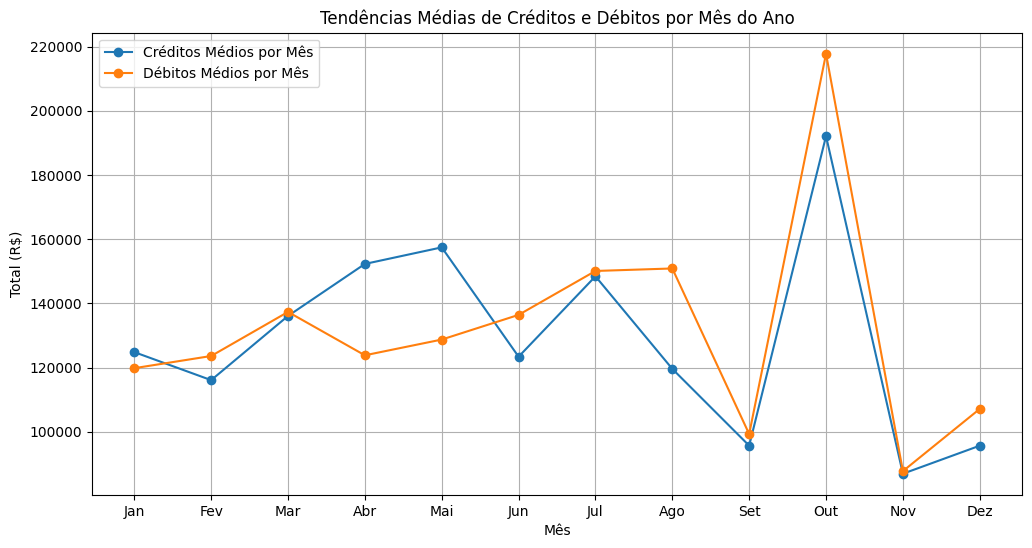

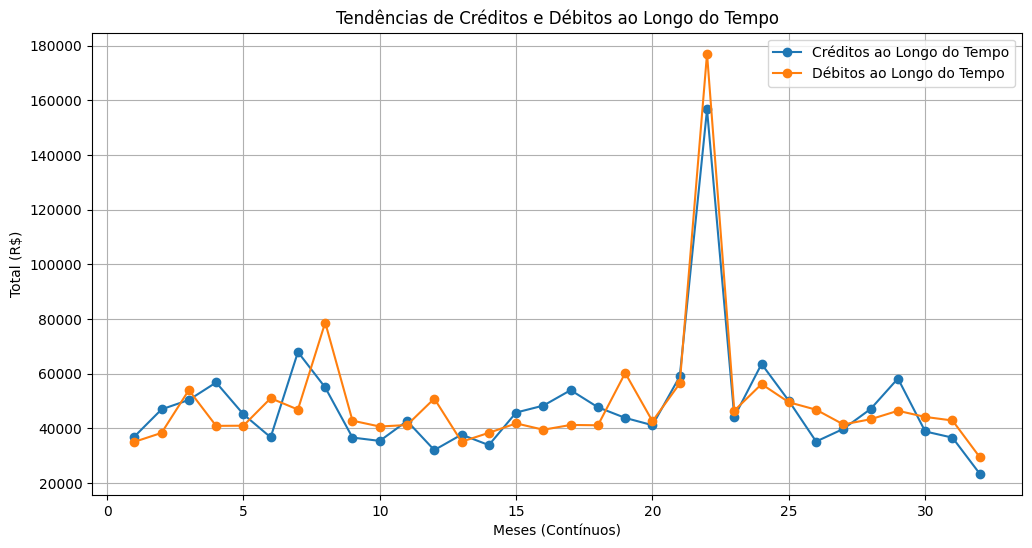

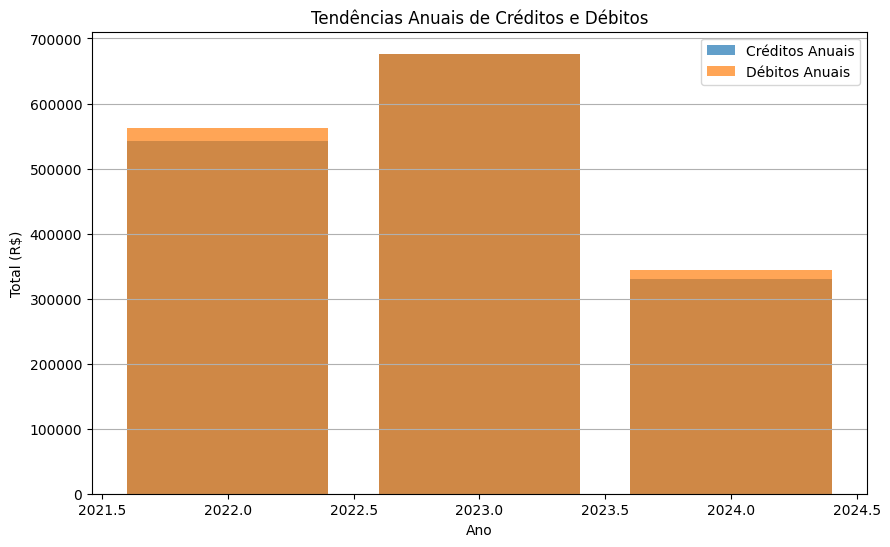

In [13]:
# Separar dados de crédito e débito
credito = df[df['type'] == 'CREDITO']
debito = df[df['type'] == 'DEBITO']

# Converter a coluna 'date' para datetime, se necessário
df['date'] = pd.to_datetime(df['date'])

# Extrair o mês e o ano para facilitar a agregação
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Agregar valores por mês
credito_por_mes = credito.groupby('month')['value'].sum().reset_index()
debito_por_mes = debito.groupby('month')['value'].sum().reset_index()

# Renomear as colunas para clareza
credito_por_mes.rename(columns={'value': 'total_credito'}, inplace=True)
debito_por_mes.rename(columns={'value': 'total_debito'}, inplace=True)

# Gráfico 1: Tendências médias por mês do ano
plt.figure(figsize=(12, 6))
plt.plot(credito_por_mes['month'], credito_por_mes['total_credito'], label='Créditos Médios por Mês', marker='o')
plt.plot(debito_por_mes['month'], debito_por_mes['total_debito'], label='Débitos Médios por Mês', marker='o')
plt.title('Tendências Médias de Créditos e Débitos por Mês do Ano')
plt.xlabel('Mês')
plt.ylabel('Total (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()

# Agregando os valores de crédito e débito por mês ao longo do tempo (linearmente)
transacoes_mensais = credito.groupby(['year', 'month'])['value'].sum().reset_index()
transacoes_mensais.rename(columns={'value': 'total_credito'}, inplace=True)
debito_mensal = debito.groupby(['year', 'month'])['value'].sum().reset_index()
debito_mensal.rename(columns={'value': 'total_debito'}, inplace=True)
transacoes_mensais = pd.merge(transacoes_mensais, debito_mensal, on=['year', 'month'], how='outer').fillna(0)

# Gráfico 2: Tendências lineares de créditos e débitos ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(transacoes_mensais['month'] + (transacoes_mensais['year'] - transacoes_mensais['year'].min()) * 12,
         transacoes_mensais['total_credito'], label='Créditos ao Longo do Tempo', marker='o')
plt.plot(transacoes_mensais['month'] + (transacoes_mensais['year'] - transacoes_mensais['year'].min()) * 12,
         transacoes_mensais['total_debito'], label='Débitos ao Longo do Tempo', marker='o')
plt.title('Tendências de Créditos e Débitos ao Longo do Tempo')
plt.xlabel('Meses (Contínuos)')
plt.ylabel('Total (R$)')
plt.legend()
plt.grid()
plt.show()

# Gráfico 3: Tendências anuais de créditos e débitos
credito_anual = credito.groupby(['year'])['value'].sum().reset_index()
debito_anual = debito.groupby(['year'])['value'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(credito_anual['year'], credito_anual['value'], alpha=0.7, label='Créditos Anuais')
plt.bar(debito_anual['year'], debito_anual['value'], alpha=0.7, label='Débitos Anuais')
plt.title('Tendências Anuais de Créditos e Débitos')
plt.xlabel('Ano')
plt.ylabel('Total (R$)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [ ]:
# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'])

# Criar cópias explícitas de credito e debito
credito = df[df['type'] == 'credito'].copy()
debito = df[df['type'] == 'debito'].copy()

# Adicionar a coluna 'day_of_year' (Dia do Ano)
credito['day_of_year'] = credito['date'].dt.dayofyear
debito['day_of_year'] = debito['date'].dt.dayofyear

# Agrupar por 'day_of_year' e 'year' para cada valor
credito_por_dia = credito.groupby(['day_of_year', 'year'])['value'].sum().reset_index()
debito_por_dia = debito.groupby(['day_of_year', 'year'])['value'].sum().reset_index()

# Pivotar os dados para visualizar por ano
credito_pivot = credito_por_dia.pivot(index='day_of_year', columns='year', values='value').fillna(0)
debito_pivot = debito_por_dia.pivot(index='day_of_year', columns='year', values='value').fillna(0)

# Plotar os dados de Créditos
plt.figure(figsize=(14, 8))
if 2022 in credito_pivot.columns:
    plt.plot(credito_pivot.index, credito_pivot[2022], label='2022', color='blue')
if 2023 in credito_pivot.columns:
    plt.plot(credito_pivot.index, credito_pivot[2023], label='2023', color='orange')
if 2024 in credito_pivot.columns:
    plt.plot(credito_pivot.index, credito_pivot[2024], label='2024', color='green')
plt.title('Comparação de Créditos por Dia do Ano')
plt.xlabel('Dia do Ano')
plt.ylabel('Total de Créditos (R$)')
plt.legend()
plt.grid()
plt.show()

# Plotar os dados de Débitos
plt.figure(figsize=(14, 8))
if 2022 in debito_pivot.columns:
    plt.plot(debito_pivot.index, debito_pivot[2022], label='2022', color='blue')
if 2023 in debito_pivot.columns:
    plt.plot(debito_pivot.index, debito_pivot[2023], label='2023', color='orange')
if 2024 in debito_pivot.columns:
    plt.plot(debito_pivot.index, debito_pivot[2024], label='2024', color='green')
plt.title('Comparação de Débitos por Dia do Ano')
plt.xlabel('Dia do Ano')
plt.ylabel('Total de Débitos (R$)')
plt.legend()
plt.grid()
plt.show()



KeyError: 2022

<Figure size 1400x800 with 0 Axes>

In [ ]:
# Adicionar a coluna 'month' (Mês)
credito['month'] = credito['date'].dt.month
debito['month'] = debito['date'].dt.month

# Adicionar a coluna 'year' (Ano)
credito['year'] = credito['date'].dt.year
debito['year'] = debito['date'].dt.year

# Agrupar por 'month' e 'year' para cada valor
credito_por_mes = credito.groupby(['month', 'year'])['value'].sum().reset_index()
debito_por_mes = debito.groupby(['month', 'year'])['value'].sum().reset_index()

# Pivotar os dados para visualizar por ano
credito_pivot = credito_por_mes.pivot(index='month', columns='year', values='value').fillna(0)
debito_pivot = debito_por_mes.pivot(index='month', columns='year', values='value').fillna(0)

# Plotar os dados de Créditos
plt.figure(figsize=(14, 8))
plt.plot(credito_pivot.index, credito_pivot[2022], label='2022', color='blue', marker='o')
plt.plot(credito_pivot.index, credito_pivot[2023], label='2023', color='orange', marker='o')
plt.plot(credito_pivot.index, credito_pivot[2024], label='2024', color='green', marker='o')
plt.title('Comparação de Créditos por Mês do Ano')
plt.xlabel('Mês')
plt.ylabel('Total de Créditos (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()

# Plotar os dados de Débitos
plt.figure(figsize=(14, 8))
plt.plot(debito_pivot.index, debito_pivot[2022], label='2022', color='blue', marker='o')
plt.plot(debito_pivot.index, debito_pivot[2023], label='2023', color='orange', marker='o')
plt.plot(debito_pivot.index, debito_pivot[2024], label='2024', color='green', marker='o')
plt.title('Comparação de Débitos por Mês do Ano')
plt.xlabel('Mês')
plt.ylabel('Total de Débitos (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()


KeyError: 2022

<Figure size 1400x800 with 0 Axes>

### Outliers

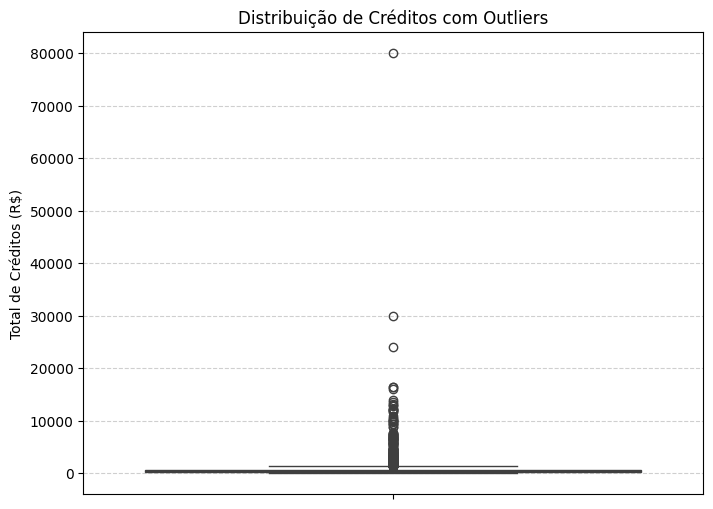

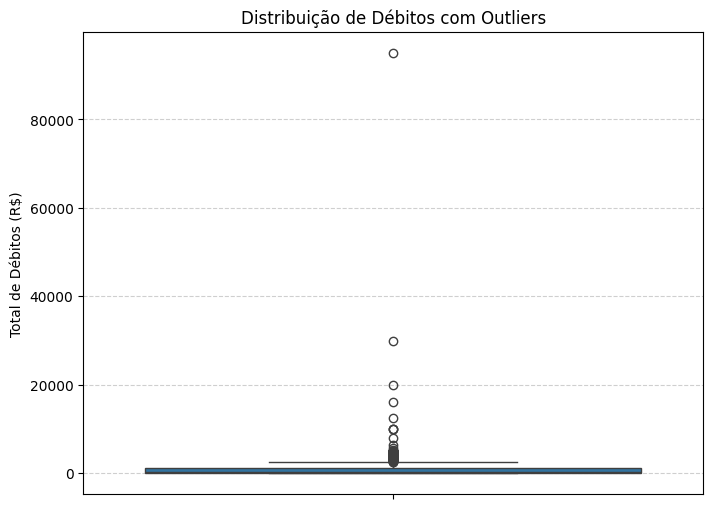

In [ ]:

# Boxplot para Créditos (todas as entradas)
plt.figure(figsize=(8, 6))
sns.boxplot(y=credito['value'])
plt.title('Distribuição de Créditos com Outliers')
plt.ylabel('Total de Créditos (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Boxplot para Débitos (todas as entradas)
plt.figure(figsize=(8, 6))
sns.boxplot(y=debito['value'])
plt.title('Distribuição de Débitos com Outliers')
plt.ylabel('Total de Débitos (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



In [ ]:
# Função ajustada para remover apenas outliers muito extremos
def remover_outliers_extremos(df, coluna, fator=3.0):
    Q1 = df[coluna].quantile(0.25)  # Primeiro quartil
    Q3 = df[coluna].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo interquartil
    limite_inferior = Q1 - fator * IQR
    limite_superior = Q3 + fator * IQR
    print(f"Limites ajustados para {coluna} (fator {fator}): {limite_inferior:.2f} a {limite_superior:.2f}")
    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Remover apenas os outliers muito extremos
credito_limpo_ajustado = remover_outliers_extremos(credito, 'value', fator=3.0)
debito_limpo_ajustado = remover_outliers_extremos(debito, 'value', fator=3.0)

print(f"Tamanho após remoção ajustada - Créditos: {credito_limpo_ajustado.shape}, Débitos: {debito_limpo_ajustado.shape}")



Limites ajustados para value (fator 3.0): -1306.69 a 2103.92
Limites ajustados para value (fator 3.0): -2900.00 a 4100.00
Tamanho após remoção ajustada - Créditos: (1523, 12), Débitos: (1817, 12)


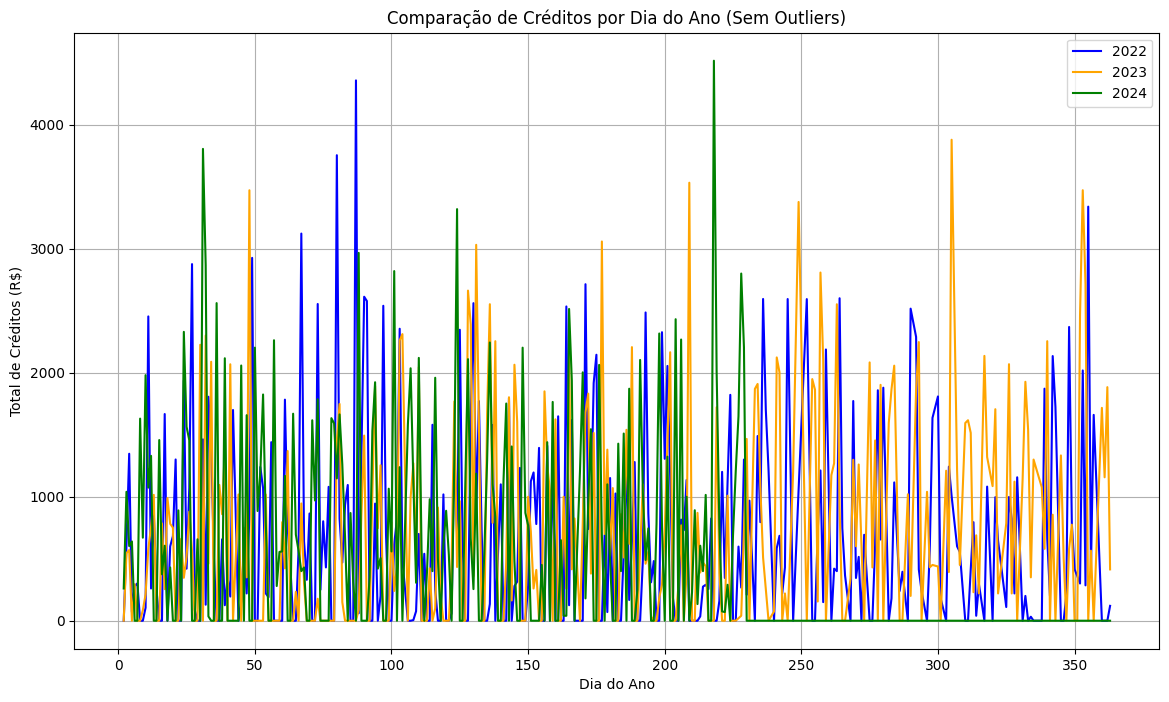

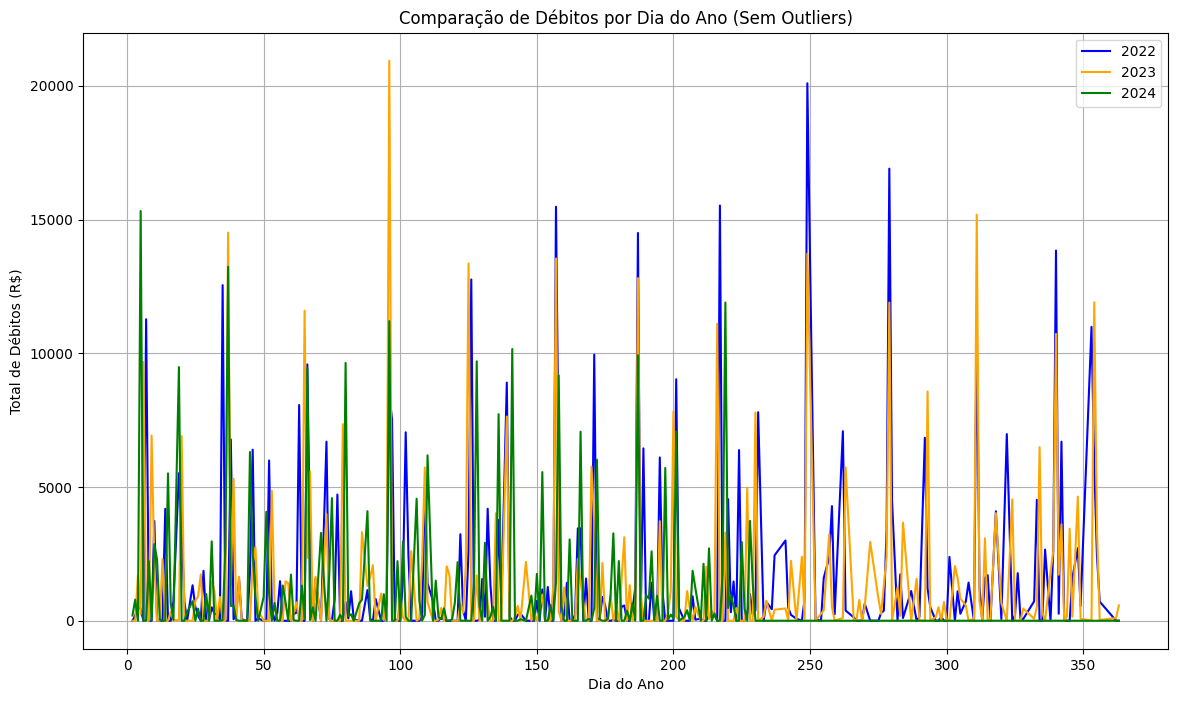

In [ ]:
# Criar cópias explícitas para evitar o Warning
credito_limpo_ajustado = credito_limpo_ajustado.copy()
debito_limpo_ajustado = debito_limpo_ajustado.copy()

# Adicionar a coluna 'day_of_year' (Dia do Ano)
credito_limpo_ajustado['day_of_year'] = credito_limpo_ajustado['date'].dt.dayofyear
debito_limpo_ajustado['day_of_year'] = debito_limpo_ajustado['date'].dt.dayofyear

# Adicionar a coluna 'year' (Ano)
credito_limpo_ajustado['year'] = credito_limpo_ajustado['date'].dt.year
debito_limpo_ajustado['year'] = debito_limpo_ajustado['date'].dt.year

# Agrupar por 'day_of_year' e 'year' para cada valor
credito_por_dia = credito_limpo_ajustado.groupby(['day_of_year', 'year'])['value'].sum().reset_index()
debito_por_dia = debito_limpo_ajustado.groupby(['day_of_year', 'year'])['value'].sum().reset_index()

# Pivotar os dados para visualizar por ano
credito_pivot = credito_por_dia.pivot(index='day_of_year', columns='year', values='value').fillna(0)
debito_pivot = debito_por_dia.pivot(index='day_of_year', columns='year', values='value').fillna(0)

# Plotar os dados de Créditos
plt.figure(figsize=(14, 8))
plt.plot(credito_pivot.index, credito_pivot[2022], label='2022', color='blue')
plt.plot(credito_pivot.index, credito_pivot[2023], label='2023', color='orange')
plt.plot(credito_pivot.index, credito_pivot[2024], label='2024', color='green')
plt.title('Comparação de Créditos por Dia do Ano (Sem Outliers)')
plt.xlabel('Dia do Ano')
plt.ylabel('Total de Créditos (R$)')
plt.legend()
plt.grid()
plt.show()

# Plotar os dados de Débitos
plt.figure(figsize=(14, 8))
plt.plot(debito_pivot.index, debito_pivot[2022], label='2022', color='blue')
plt.plot(debito_pivot.index, debito_pivot[2023], label='2023', color='orange')
plt.plot(debito_pivot.index, debito_pivot[2024], label='2024', color='green')
plt.title('Comparação de Débitos por Dia do Ano (Sem Outliers)')
plt.xlabel('Dia do Ano')
plt.ylabel('Total de Débitos (R$)')
plt.legend()
plt.grid()
plt.show()


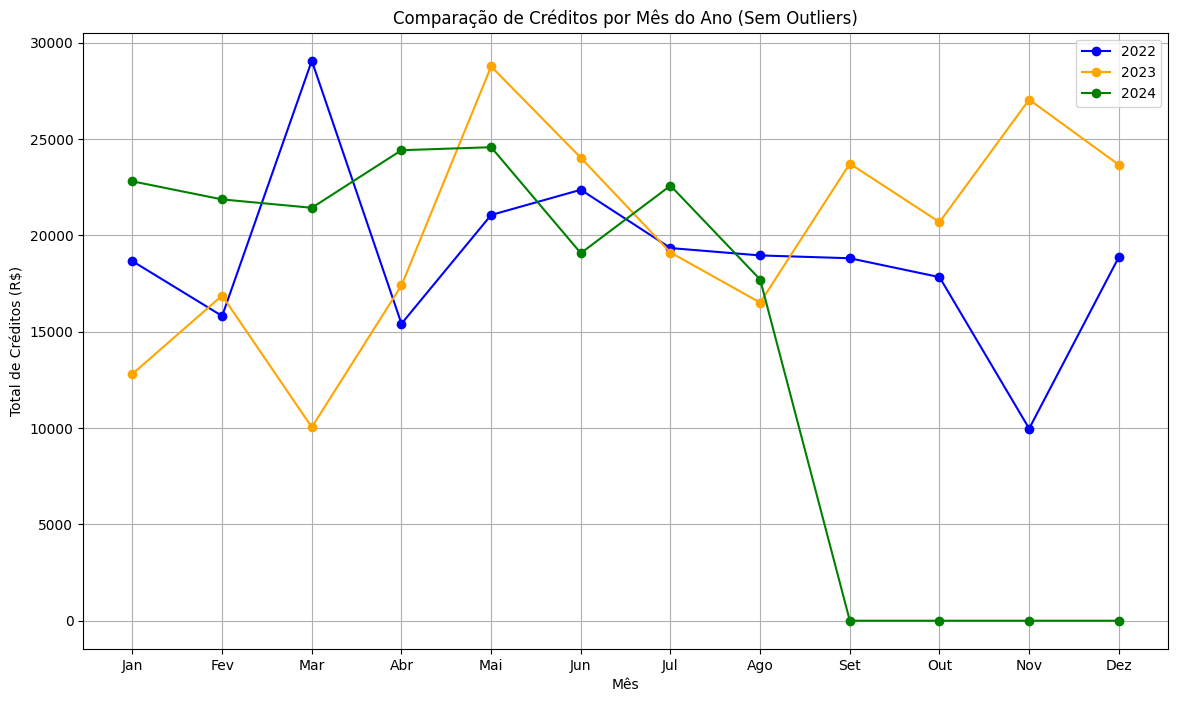

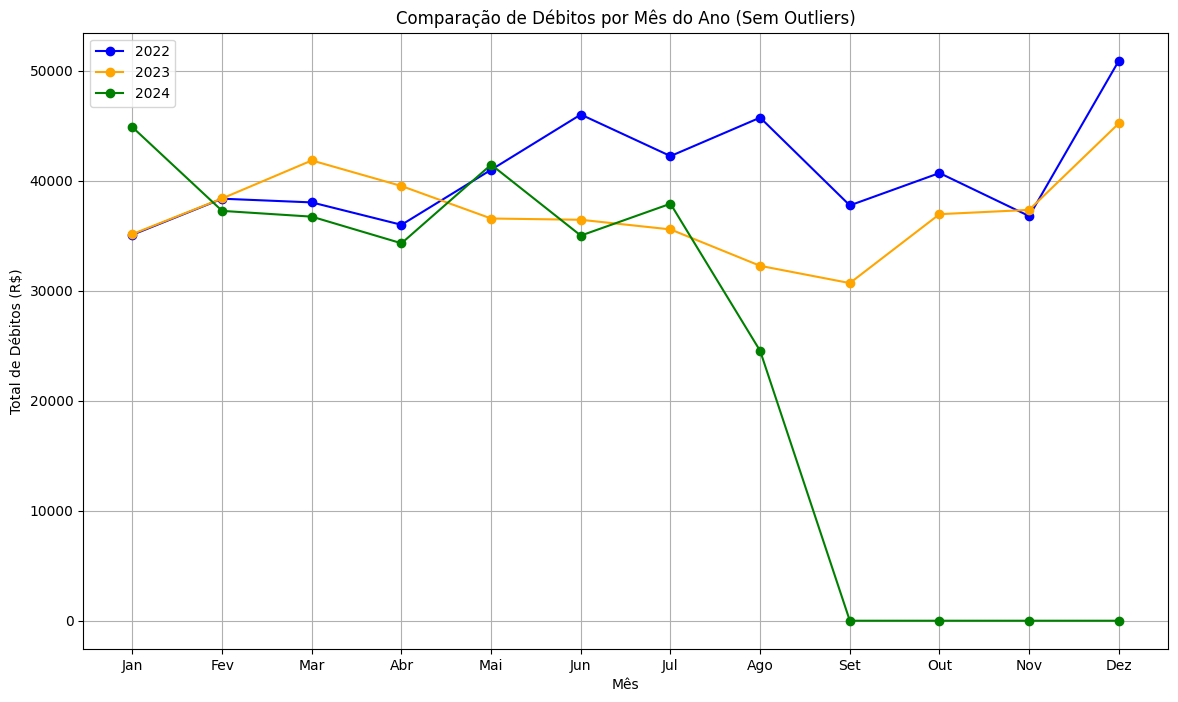

In [ ]:
# Garantir que estamos atualizando explicitamente as colunas no DataFrame ajustado
credito_limpo_ajustado.loc[:, 'month'] = credito_limpo_ajustado['date'].dt.month
debito_limpo_ajustado.loc[:, 'month'] = debito_limpo_ajustado['date'].dt.month

credito_limpo_ajustado.loc[:, 'year'] = credito_limpo_ajustado['date'].dt.year
debito_limpo_ajustado.loc[:, 'year'] = debito_limpo_ajustado['date'].dt.year

# Agrupar por 'month' e 'year' para cada valor
credito_por_mes = credito_limpo_ajustado.groupby(['month', 'year'])['value'].sum().reset_index()
debito_por_mes = debito_limpo_ajustado.groupby(['month', 'year'])['value'].sum().reset_index()

# Pivotar os dados para visualizar por ano
credito_pivot = credito_por_mes.pivot(index='month', columns='year', values='value').fillna(0)
debito_pivot = debito_por_mes.pivot(index='month', columns='year', values='value').fillna(0)

# Plotar os dados de Créditos
plt.figure(figsize=(14, 8))
plt.plot(credito_pivot.index, credito_pivot[2022], label='2022', color='blue', marker='o')
plt.plot(credito_pivot.index, credito_pivot[2023], label='2023', color='orange', marker='o')
plt.plot(credito_pivot.index, credito_pivot[2024], label='2024', color='green', marker='o')
plt.title('Comparação de Créditos por Mês do Ano (Sem Outliers)')
plt.xlabel('Mês')
plt.ylabel('Total de Créditos (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()

# Plotar os dados de Débitos
plt.figure(figsize=(14, 8))
plt.plot(debito_pivot.index, debito_pivot[2022], label='2022', color='blue', marker='o')
plt.plot(debito_pivot.index, debito_pivot[2023], label='2023', color='orange', marker='o')
plt.plot(debito_pivot.index, debito_pivot[2024], label='2024', color='green', marker='o')
plt.title('Comparação de Débitos por Mês do Ano (Sem Outliers)')
plt.xlabel('Mês')
plt.ylabel('Total de Débitos (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()


   year  month  total_credito  total_debito     saldo
0  2022      1       36994.51      35093.80   1900.71
1  2022      2       46985.01      38372.54   8612.47
2  2022      3       50432.77      54035.86  -3603.09
3  2022      4       56811.26      40946.13  15865.13
4  2022      5       45184.27      41003.18   4181.09


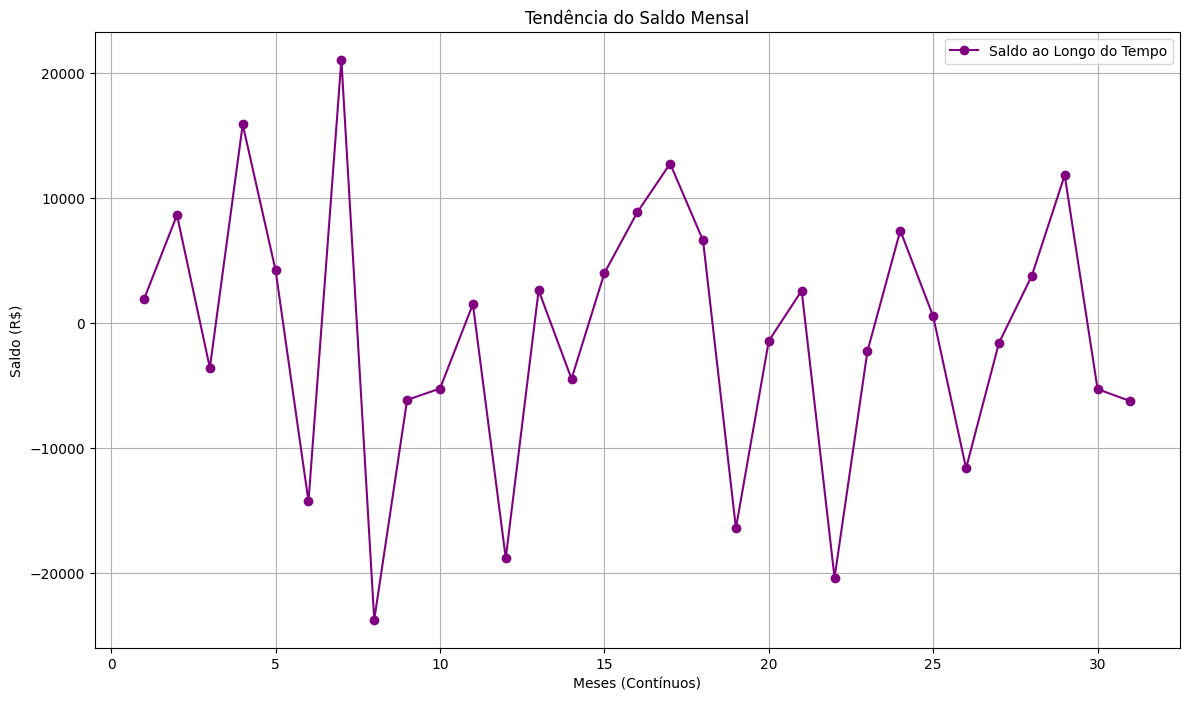

In [ ]:
# Criar a variável 'saldo' como diferença entre créditos e débitos
transacoes_mensais['saldo'] = transacoes_mensais['total_credito'] - transacoes_mensais['total_debito']

# Verificar o DataFrame com a nova coluna
print(transacoes_mensais.head())

# Visualizar o saldo ao longo do tempo
plt.figure(figsize=(14, 8))
plt.plot(transacoes_mensais['month'] + (transacoes_mensais['year'] - transacoes_mensais['year'].min()) * 12,
         transacoes_mensais['saldo'], label='Saldo ao Longo do Tempo', color='purple', marker='o')
plt.title('Tendência do Saldo Mensal')
plt.xlabel('Meses (Contínuos)')
plt.ylabel('Saldo (R$)')
plt.legend()
plt.grid()
plt.show()


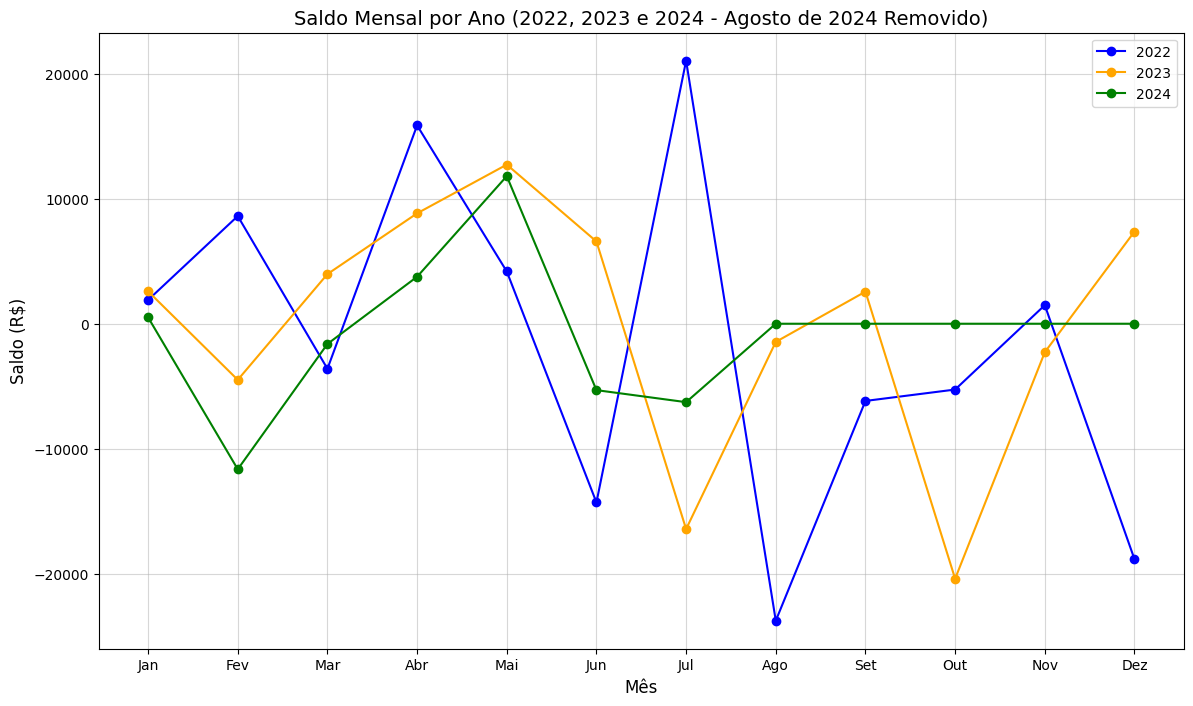

   year  month     saldo
0  2022      1   1900.71
1  2022      2   8612.47
2  2022      3  -3603.09
3  2022      4  15865.13
4  2022      5   4181.09


In [ ]:
# Criar a variável 'saldo' como a diferença entre créditos e débitos
transacoes_mensais['saldo'] = transacoes_mensais['total_credito'] - transacoes_mensais['total_debito']

# Remover o mês de agosto de 2024
transacoes_mensais = transacoes_mensais[~((transacoes_mensais['year'] == 2024) & (transacoes_mensais['month'] == 8))]

# Renomear o DataFrame consolidado para 'saldo_mensal'
saldo_mensal = transacoes_mensais[['year', 'month', 'saldo']].copy()

# Pivotar os dados para exibir os saldos mensais por ano
saldo_pivot = saldo_mensal.pivot(index='month', columns='year', values='saldo').fillna(0)

# Plotar o gráfico de saldo por mês para 2022, 2023 e 2024
plt.figure(figsize=(14, 8))
plt.plot(saldo_pivot.index, saldo_pivot[2022], label='2022', color='blue', marker='o')
plt.plot(saldo_pivot.index, saldo_pivot[2023], label='2023', color='orange', marker='o')
plt.plot(saldo_pivot.index, saldo_pivot[2024], label='2024', color='green', marker='o')

# Configurações do gráfico
plt.title('Saldo Mensal por Ano (2022, 2023 e 2024 - Agosto de 2024 Removido)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Saldo (R$)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Exibir as primeiras linhas do DataFrame saldo_mensal
print(saldo_mensal.head())


### **Variável Dependente (Y):**
O valor total de `saldo` mensais

### **Variável Independente (X):**
O histórico dos valores passados na série temporal, sem variáveis exógenas.

In [ ]:
# Remover outliers extremos nos dados de crédito e débito
credito_limpo_ajustado = remover_outliers_extremos(credito, 'value', fator=3.0)
debito_limpo_ajustado = remover_outliers_extremos(debito, 'value', fator=3.0)

# Criar saldo mensal (diferença entre créditos e débitos)
transacoes_mensais['saldo'] = transacoes_mensais['total_credito'] - transacoes_mensais['total_debito']

# Remover o mês de agosto de 2024 (incompleto)
transacoes_mensais = transacoes_mensais[~((transacoes_mensais['year'] == 2024) & (transacoes_mensais['month'] == 8))]

# Consolidar o saldo mensal em um DataFrame para análises futuras
saldo_mensal = transacoes_mensais[['year', 'month', 'saldo']].copy()

# Teste de estacionaridade no saldo
saldo_series = saldo_mensal.groupby(['year', 'month'])['saldo'].sum()

print("\nVerificando Estacionaridade para o Saldo Mensal:")
p_value_saldo = test_stationarity(saldo_series)

# Aplicar diferenciação caso a série não seja estacionária
if p_value_saldo > 0.05:
    print("\nA série de saldo NÃO é estacionária. Aplicando diferenciação.")
    saldo_series = saldo_series.diff().dropna()
    print("\nApós Diferenciação - Verificando Estacionaridade para o Saldo:")
    test_stationarity(saldo_series)

# Plotar gráficos ACF e PACF para o saldo
plt.figure(figsize=(12, 6))
plot_acf(saldo_series, lags=12, ax=plt.gca())
plt.title("ACF (Autocorrelação) - Saldo", fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(saldo_series, lags=12, ax=plt.gca(), method='ywm')
plt.title("PACF (Autocorrelação Parcial) - Saldo", fontsize=14)
plt.grid()
plt.show()


Limites ajustados para value (fator 3.0): -1306.69 a 2103.92
Limites ajustados para value (fator 3.0): -2900.00 a 4100.00

Verificando Estacionaridade para o Saldo Mensal:


NameError: name 'test_stationarity' is not defined

## SARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurar índice baseado em datas mensais
saldo_series.index = pd.date_range(start="2022-01-01", periods=len(saldo_series), freq="MS")

# Teste de estacionaridade
print("\nVerificando Estacionaridade para o Saldo Mensal:")
p_value_saldo = test_stationarity(saldo_series)

# Aplicar diferenciação, se necessário
if p_value_saldo > 0.05:
    print("\nA série de saldo NÃO é estacionária. Aplicando diferenciação.")
    saldo_series = saldo_series.diff().dropna()
    print("\nApós Diferenciação - Verificando Estacionaridade para o Saldo:")
    test_stationarity(saldo_series)

# Divisão em treino e teste
train_data = saldo_series[:'2024-07']
test_data = saldo_series['2024-08':]

# Configuração do modelo SARIMA
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12

# Treinamento do modelo SARIMA
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m),
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Exibir o resumo do modelo
print(model_fit.summary())

# Previsões para o período de teste
forecast_index = pd.date_range(start="2024-08-01", periods=len(test_data), freq="MS")
# Previsão com o modelo ajustado
forecast_steps = len(test_data)
predictions = model_fit.get_forecast(steps=forecast_steps)

# Atribuir o índice correto às previsões
predictions_series = predictions.predicted_mean
predictions_series.index = forecast_index


# Avaliação do modelo
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)

print("\nAvaliação do Modelo SARIMA:")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Erro Médio Quadrático (MSE): {mse:.2f}")

# Gráficos de treino, teste e previsão
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data, label="Treino", color="blue")
plt.plot(test_data.index, test_data, label="Teste", color="orange")
plt.plot(predictions.index, predictions, label="Previsão", color="green", linestyle="--")
plt.title("Série Temporal Predita com SARIMA", fontsize=14)
plt.xlabel("Tempo", fontsize=12)
plt.ylabel("Saldo (R$)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


NameError: name 'saldo_series' is not defined